In [3]:
import datetime as dt       
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
df = pd.read_csv("monthly-sunspots.csv")
df.head(5)

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Month     2820 non-null   object 
 1   Sunspots  2820 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB


In [6]:
df.isna().sum()

Month       0
Sunspots    0
dtype: int64

In [7]:
df['Date'] = pd.to_datetime(df['Month'].astype(str) + "-01")
df.set_index('Date', inplace=True)
df.head(5)

,Month,Sunspots
Date,,
1749-01-01,1749-01,58.0
1749-02-01,1749-02,62.6
1749-03-01,1749-03,70.0
1749-04-01,1749-04,55.7
1749-05-01,1749-05,85.0


In [8]:
df = df.drop(columns=['Month'])

In [20]:
decompose_data = seasonal_decompose(df, model = "additive", period = 12)
decompose_data.plot();

ValueError: This function does not handle missing values

In [10]:
def check_stationarity(df, var):
    df['rollMean'] = df[var].rolling(window = 12).mean()
    df['rollStd'] = df[var].rolling(window = 12).std()

    adf = adfuller(df[var], autolag='AIC')
    stats = pd.Series(adf[0:4], index = ['Test Statistic', 'p-value', 'No of lags used', 'No of obs used'])
    print(stats)
    print()

    for key, values in adf[4].items():
        print("Criticality", key, ":", values)

    sns.lineplot(data=df, x = df.index, y = df[var])
    sns.lineplot(data=df, x = df.index, y = df.rollMean )
    sns.lineplot(data=df, x = df.index, y = df.rollStd)

Test Statistic    -9.567668e+00
p-value            2.333452e-16
No of lags used    2.700000e+01
No of obs used     2.792000e+03
dtype: float64

Criticality 1% : -3.432694313168895
Criticality 5% : -2.862575752726396
Criticality 10% : -2.5673213632123297


c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: Futur

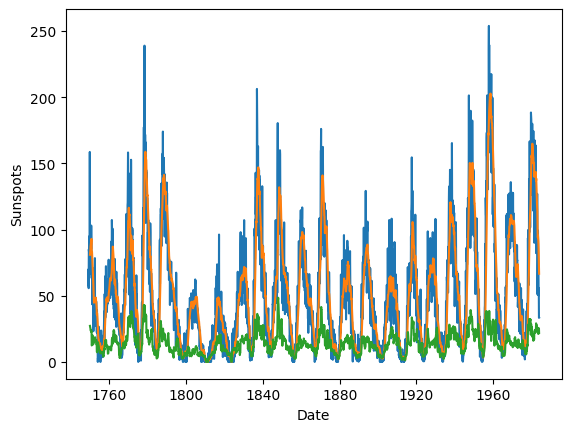

In [11]:
check_stationarity(df, 'Sunspots')

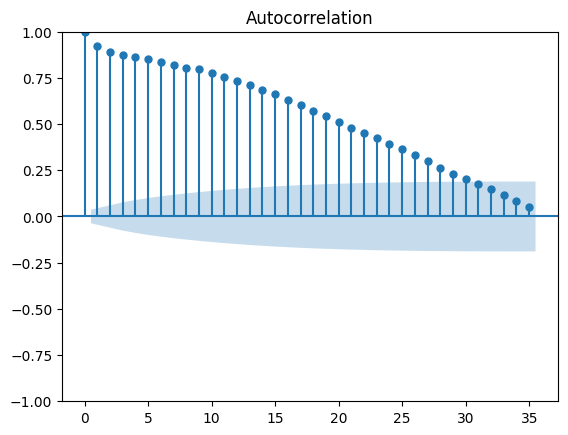

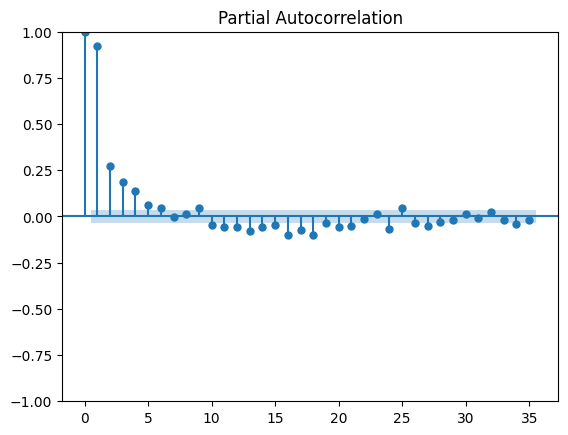

In [12]:
plot_acf(df['Sunspots']);
plot_pacf(df['Sunspots']);

In [13]:
train = df[:round(len(df)*70/100)]
test = df[round(len(df)*70/100):]

In [14]:
arimamodel = ARIMA(train['Sunspots'], order = (5,0,30))
amodel = arimamodel.fit()

amodel.summary()

c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Sunspots   No. Observations:                 1974
Model:                ARIMA(5, 0, 30)   Log Likelihood               -8078.995
Date:                Tue, 31 Oct 2023   AIC                          16231.990
Time:                        22:51:00   BIC                          16438.739
Sample:                    01-01-1749   HQIC                         16307.954
                         - 06-01-1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.0582      4.961      9.082      0.000      35.334      54.782
ar.L1         -0.0126      0.485     -0.026      0.979      -0.963       0.938
ar.L2          1.4441      0.242      5.972      0.000       0.970       1.918
ar.L3          0.5461      0.827      0.660      0.509      -1.076       2.168
ar.L4         -0.5829      0.221     -2.642      0.008      -1.015      -0.150
ar.L5         -0.4082      0.424     -0.963      0.335      -1.239       0.422
ma.L1          0.5188      0.486      1.068      0.286      -0.433       1.471
ma.L2         -1.0635      0.258     -4.129      0.000      -1.568      -0.559
ma.L3         -0.9698      0.680     -1.426      0.154      -2.303       0.363
ma.L4          0.0880      0.339      0.260      0.795      -0.576       0.752
ma.L5          0.3903      0.239      1.630      0.103      -0.079       0.860
ma.L6          0.1683      0.099      1.700      0.089      -0.026       0.362
ma.L7          0.0171      0.055      0.308      0.758      -0.092       0.126
ma.L8         -0.0743      0.036     -2.057      0.040      -0.145      -0.004
ma.L9          0.0670      0.052      1.297      0.194      -0.034       0.168
ma.L10         0.1123      0.058      1.946      0.052      -0.001       0.225
ma.L11        -0.0081      0.066     -0.123      0.902      -0.137       0.121
ma.L12        -0.0408      0.045     -0.898      0.369      -0.130       0.048
ma.L13        -0.0246      0.038     -0.645      0.519      -0.099       0.050
ma.L14        -0.0029      0.035     -0.081      0.935      -0.072       0.067
ma.L15         0.0334      0.035      0.952      0.341      -0.035       0.102
ma.L16        -0.0354      0.039     -0.899      0.369      -0.113       0.042
ma.L17        -0.0668      0.046     -1.455      0.146      -0.157       0.023
ma.L18        -0.0249      0.051     -0.490      0.624      -0.125       0.075
ma.L19         0.0017      0.042      0.040      0.968      -0.080       0.083
ma.L20         0.0217      0.038      0.568      0.570      -0.053       0.096
ma.L21        -0.0055      0.041     -0.134      0.893      -0.086       0.075
ma.L22        -0.0334      0.043     -0.786      0.432      -0.117       0.050
ma.L23         0.0947      0.042      2.229      0.026       0.011       0.178
ma.L24         0.0759      0.070      1.086      0.277      -0.061       0.213
ma.L25         0.0021      0.052      0.040      0.968      -0.100       0.104
ma.L26         0.0035      0.048      0.072      0.943      -0.091       0.098
ma.L27        -0.0520      0.042     -1.240      0.215      -0.134       0.030
ma.L28        -0.0754      0.036     -2.102      0.036      -0.146      -0.005
ma.L29        -0.0136      0.036     -0.375      0.707      -0.085       0.057
ma.L30         0.0507      0.026      1.948      0.051      -0.000       0.102
sigma2       208.4627      4.254     49.002      0.000     200.125     216.801
=================================================================================

In [15]:
pred1 = amodel.predict(start = test.index[0], end = test.index[-1])

In [16]:
df['arimapred'] = pred1

c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: Futur

<Axes: xlabel='Date', ylabel='Sunspots'>

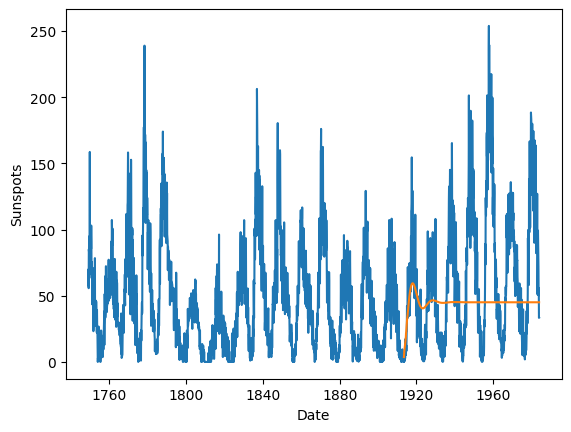

In [17]:
sns.lineplot(data = df, x = df.index, y = df['Sunspots'])
sns.lineplot(data = df, x = df.index, y = df['arimapred'])

In [18]:
mse = np.sqrt(mean_squared_error(test['Sunspots'], df['arimapred'].dropna()))
mse

54.66701951697747

In [19]:
sarimamodel = SARIMAX(train['Sunspots'], order = (5,0,11), seasonal_order= (5,0,11,12))
smodel = sarimamodel.fit()
smodel.summary()

c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Kavita manoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             Sunspots   No. Observations:                 1974
Model:             SARIMAX(5, 0, 11)x(5, 0, 11, 12)   Log Likelihood               -8107.160
Date:                              Tue, 31 Oct 2023   AIC                          16280.320
Time:                                      23:41:09   BIC                          16464.718
Sample:                                  01-01-1749   HQIC                         16348.072
                                       - 06-01-1913                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5557      1.141      0.487      0.626      -1.681       2.792
ar.L2          0.7003      0.710      0.986      0.324      -0.692       2.092
ar.L3          0.4925      0.696      0.707      0.479      -0.872       1.857
ar.L4         -0.7045      0.596     -1.183      0.237      -1.872       0.463
ar.L5         -0.0529      0.857     -0.062      0.951      -1.732       1.626
ma.L1         -0.0310      1.141     -0.027      0.978      -2.267       2.205
ma.L2         -0.5927      0.132     -4.485      0.000      -0.852      -0.334
ma.L3         -0.7483      0.607     -1.232      0.218      -1.939       0.442
ma.L4          0.3345      0.856      0.391      0.696      -1.343       2.012
ma.L5          0.1494      0.439      0.340      0.734      -0.712       1.011
ma.L6          0.0980      0.139      0.705      0.481      -0.175       0.370
ma.L7         -0.0143      0.108     -0.132      0.895      -0.226       0.198
ma.L8         -0.0173      0.035     -0.498      0.618      -0.085       0.051
ma.L9          0.0702      0.035      2.014      0.044       0.002       0.139
ma.L10         0.0462      0.078      0.593      0.553      -0.106       0.199
ma.L11        -0.0238      0.051     -0.471      0.638      -0.123       0.075
ar.S.L12       0.9424      3.890      0.242      0.809      -6.682       8.567
ar.S.L24       0.0543      4.901      0.011      0.991      -9.552       9.660
ar.S.L36      -0.3239      3.294     -0.098      0.922      -6.779       6.131
ar.S.L48      -0.0985      4.149     -0.024      0.981      -8.230       8.033
ar.S.L60       0.3637      2.499      0.146      0.884      -4.534       5.261
ma.S.L12      -0.9730      3.892     -0.250      0.803      -8.601       6.655
ma.S.L24      -0.0344      5.015     -0.007      0.995      -9.863       9.794
ma.S.L36       0.3141      3.347      0.094      0.925      -6.246       6.874
ma.S.L48       0.0844      4.181      0.020      0.984      -8.111       8.279
ma.S.L60      -0.3384      2.622     -0.129      0.897      -5.478       4.801
ma.S.L72      -0.0061      0.186     -0.033      0.974      -0.371       0.358
ma.S.L84       0.0114      0.105      0.108      0.914      -0.195       0.218
ma.S.L96       0.0272      0.092      0.296      0.767      -0.153       0.207
ma.S.L108      0.0176      0.161      0.109      0.913      -0.298       0.333
ma.S.L120     -0.0154      0.040     -0.390      0.697      -0.093       0.062
ma.S.L132      0.0041      0.046      0.091      0.928      -0.085       0.093
sigma2       216.5378      4.458     48.569      0.000     207.800     225.276
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1360.93
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity 